<a href="https://colab.research.google.com/github/MBrandao07/Previsao_Demandas_Market_Show/blob/main/Codigos/1_Projeto_Previs%C3%A3o_de_demanda_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Entendimento do negócio

As lojas físicas de supermercado estão sempre em uma situação delicada com relação à previsão de compras e vendas.

Se a previsão é maior que a demanda, os supermercadistas ficam com produtos perecíveis em excesso.

Assim como demanda superior à previsão leva ao esgotamento rápido de itens populares, resultando em perda de receita e clientes insatisfeitos.

O problema se torna mais complexo à medida que os varejistas adicionam novas localidades com necessidades únicas, novos produtos, gostos sazonais em constante mudança e marketing de produtos imprevisível.

A MarketShow, uma grande rede de supermercados, sabe bem disso. Eles operam alguns supermercados, com mais de 200.000 produtos diferentes em suas prateleiras.

Atualmente, eles dependem de métodos de previsão utilizando pouquíssimos dados como insumo além de pouca automação para executar os planos.

Dessa forma, a MarketShow gostaria de substituir o modelo preditivo vigente por outro mais performático visando ter previsões com maior precisão. O modelo deve ser capaz de prever a demanda dos próximos 15 dias.

## Objetivo

- Criar um modelo superior ao modelo já existente, que seja capaz de prever a demanda dos próximos 15 dias.

# 2- Entendimento dos dados

Temos um total de 6 planilhas nos fornecendo diferentes informações, que estão relacionadas entre si.

- train - Possui os dados dos produtos e quantidade de vendas que serão utilizados durante o treinamento do modelo;

- test - Possui os dados dos produtos e quantidade de vendas que serão utilizados durante a validação do modelo;

- oil - É uma base que possui a data e o preço do petróleo, sendo essa uma variável externa que impacta no produto;

- holidays_events - Possui informações sobre datas de feriados, locais e descrições, o que pode impactar na demanda de determinados produtos;

- stores - Possui informações das lojas, como cidade, estado, tipo e o cluster que elas pertencem;

- transactions - Apresenta informações das transações, incluindo numero da loja e a data em que ocorreram.

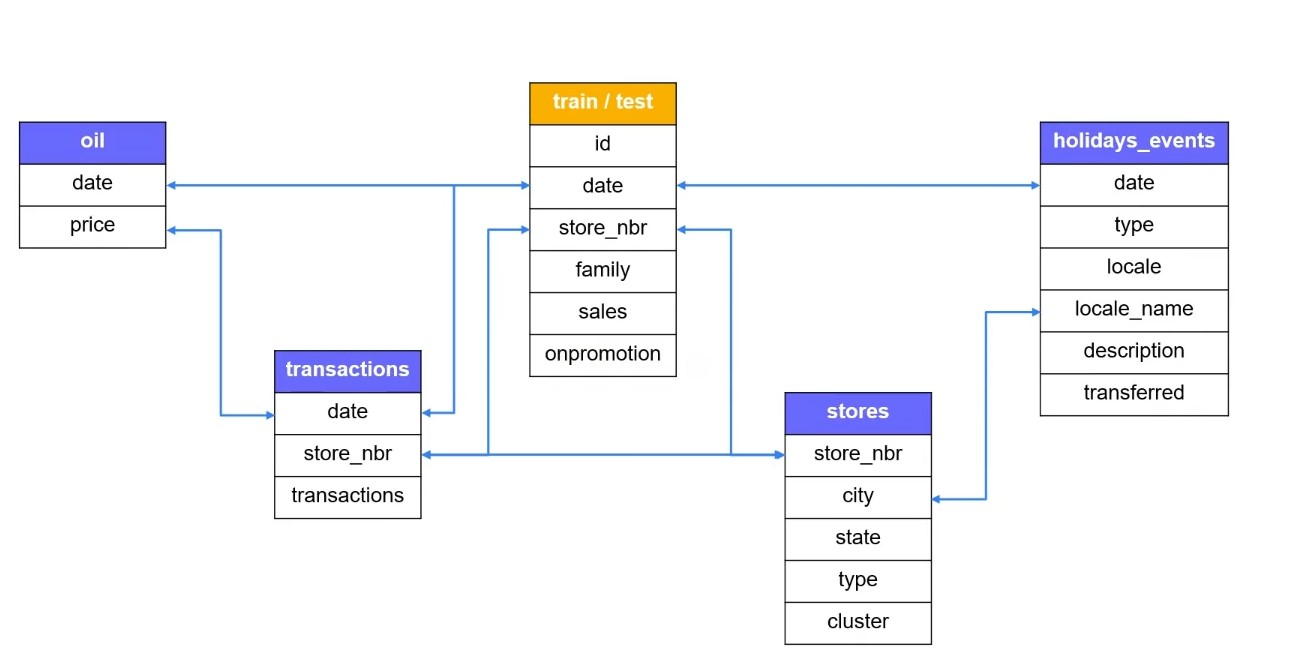

## Funções

In [ ]:
# Função para gerar os metadados do dataframe
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

## Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Conectando ao google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# configurando pra exibir todas as colunas
pd.set_option('display.max_columns', None)

## Análise exploratória dos dados

In [ ]:
# importando a base de dados principal
train = pd.read_csv('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,650430,2014-01-02,1,AUTOMOTIVE,3.0,0
1,650431,2014-01-02,1,BABY CARE,0.0,0
2,650432,2014-01-02,1,BEAUTY,6.0,0
3,650433,2014-01-02,1,BEVERAGES,2524.0,0
4,650434,2014-01-02,1,BOOKS,0.0,0


In [ ]:
# verificando o tamanho da base
train.shape

(205095, 6)

### Verificando os metadados

In [ ]:
generate_metadata(train)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,205095
1,date,object,0,0.0,1243
2,store_nbr,int64,0,0.0,5
3,family,object,0,0.0,33
4,sales,float64,0,0.0,50159
5,onpromotion,int64,0,0.0,229


- Temos 5 lojas
- 33 familias de produtos
- 1243 datas diferentes
- A coluna data está no formato object e não datetime

In [ ]:
# convertendo a coluna "date" para datetime
train['date'] = pd.to_datetime(train['date'])

In [ ]:
# criando as colunas ano e mês de referência
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['month_reference'] = train['date'].dt.strftime('%Y%m')

train.head()

,id,date,store_nbr,family,sales,onpromotion,month,year,month_reference
0,650430,2014-01-02,1,AUTOMOTIVE,3.0,0,1,2014,201401
1,650431,2014-01-02,1,BABY CARE,0.0,0,1,2014,201401
2,650432,2014-01-02,1,BEAUTY,6.0,0,1,2014,201401
3,650433,2014-01-02,1,BEVERAGES,2524.0,0,1,2014,201401
4,650434,2014-01-02,1,BOOKS,0.0,0,1,2014,201401


In [ ]:
# verificando o primeiro e o último mês da base
print(f"O mês mais antigo é {train['month_reference'].min()}")
print(f"O mês mais recente é {train['month_reference'].max()}")

O mês mais antigo é 201401
O mês mais recente é 201705


Então temos dados da base de treino de Janeiro de 2014 até Maio de 2017

## Testes de sanidade

Vamos realizar testes de sanidade para verificar os principais números, como por exemplo:

- Quantidade de vendas por mês

- Comportamento de venda em função da data, loja, familia de produto ou promoção.

In [ ]:
vendas_mes_ref = train.groupby('month_reference')['sales'].sum().reset_index()
vendas_mes_ref.head()

,month_reference,sales
0,201401,2.406680e+06
1,201402,1.390560e+06
2,201403,2.472963e+06
3,201404,1.502058e+06
4,201405,1.571610e+06


### Total de vendas por mês de referência

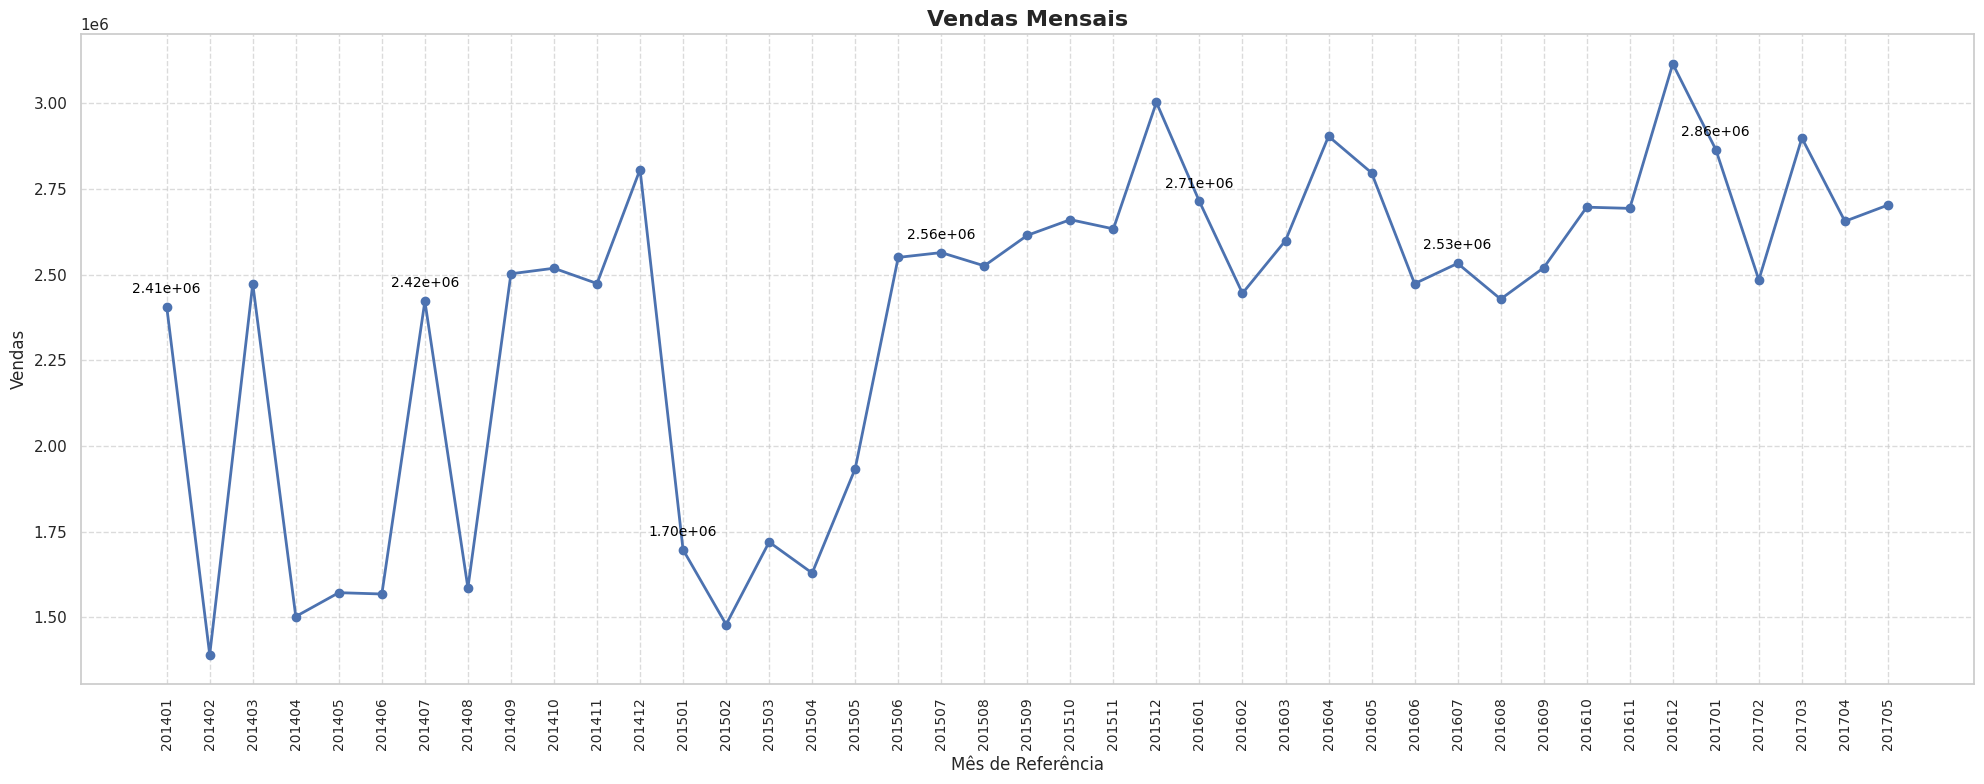

In [ ]:
# Definindo o estilo do seaborn
sns.set(style='whitegrid')

# Plotando um gráfico de linhas
plt.figure(figsize=(20, 8))
plt.plot(vendas_mes_ref['month_reference'].astype(str), vendas_mes_ref['sales'], marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas Mensais', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para alguns pontos
for i in range(0, len(vendas_mes_ref), 6):
  plt.annotate(f'{vendas_mes_ref["sales"].iloc[i]:.2e}',
  (vendas_mes_ref["month_reference"].iloc[i], vendas_mes_ref["sales"].iloc[i]),
  textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color='black')

plt.show()

É possível retirar algumas informações do gráfico, como por exemplo:

- O período entre janeiro de 2014 e junho de 2015 apresentou uma alta variação nas vendas, chegando a caso de mais de 1 M de vendas de um mês pra outro, então é necessário identificar o que houve nesse período;

- O mês de fevereiro sempre apresenta uma queda de vendas em relação ao mês de janeiro;

- o mês de dezembro é o mês que mais apresentou vendas em todos os anos.

### Total de vendas por loja e mês de referência

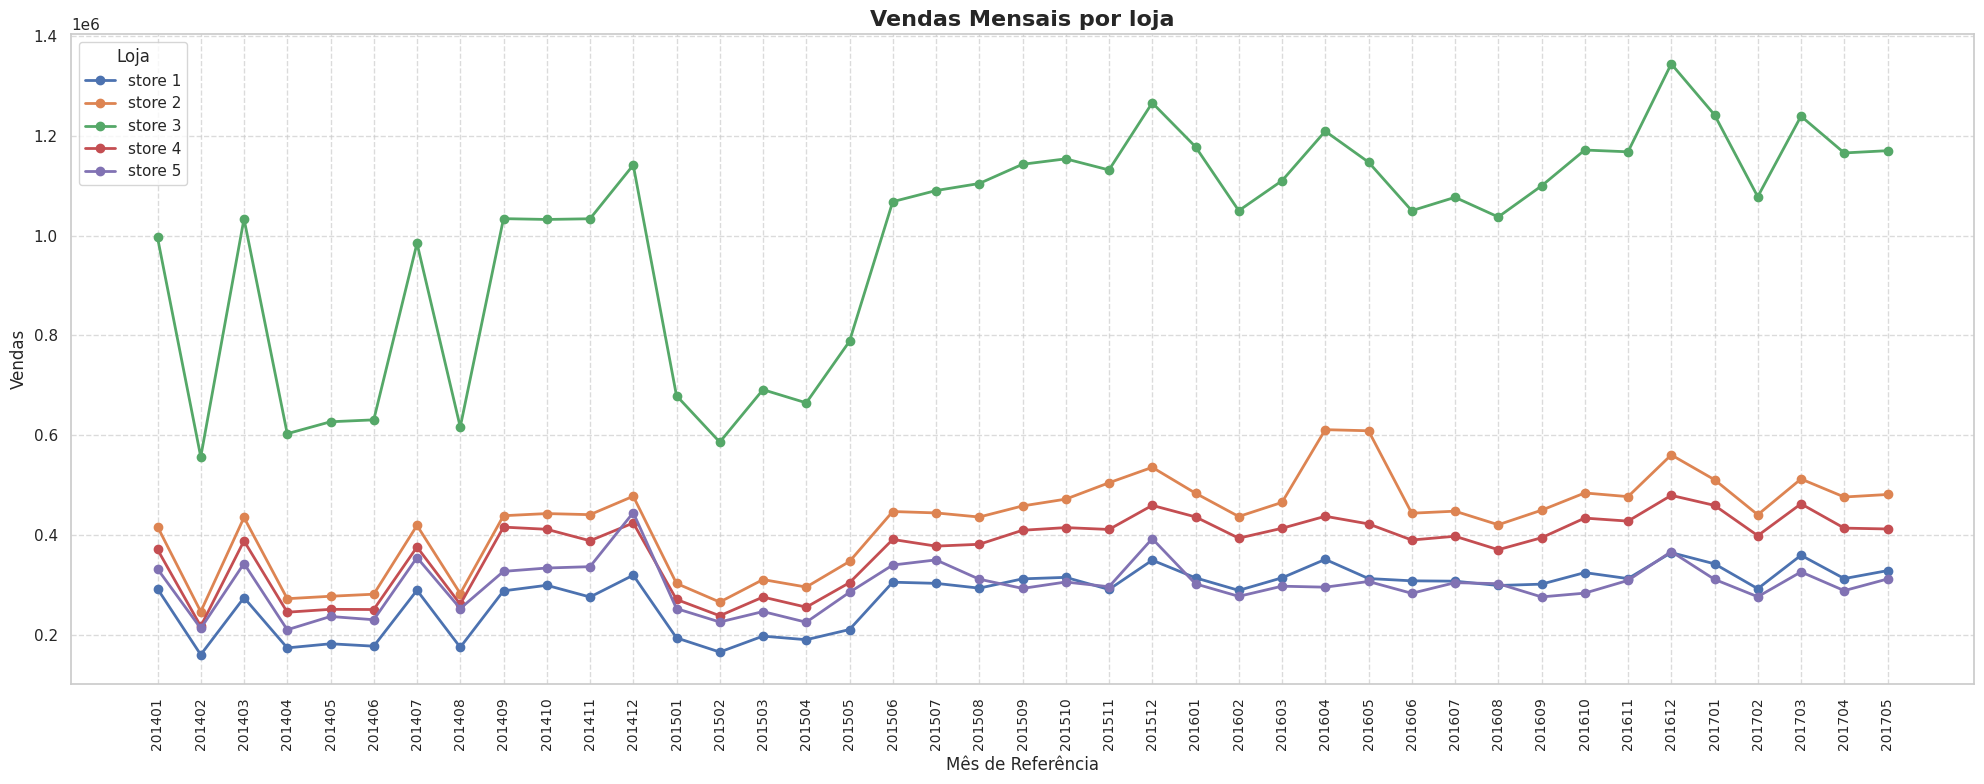

In [ ]:
df_loja_mes_ref = train.groupby(['store_nbr', 'month_reference'])['sales'].sum().reset_index()

# Definindo o estilo do seaborn
sns.set(style='whitegrid')

# Plotando um gráfico de linhas
plt.figure(figsize=(20, 8))

for store in df_loja_mes_ref['store_nbr'].unique():
    store_data = df_loja_mes_ref[df_loja_mes_ref['store_nbr'] == store]
    plt.plot(store_data['month_reference'], store_data['sales'], marker='o', linestyle='-',label=f'store {store}', linewidth=2, markersize=6)


plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas Mensais por loja', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Loja', loc='upper left')

plt.show()

- É possíve notar que as lojas 1, 2, 4 e 5 possuem uma quantida de vendas parecida, mas a loja 3 é disparada a que mais vende;

- Todas as lojas apresentaram o mesmo comportamente oscilatório entre janeiro de 2014 e junho de 2015.

### Total de produtos vendidos por categoria durante todo o período

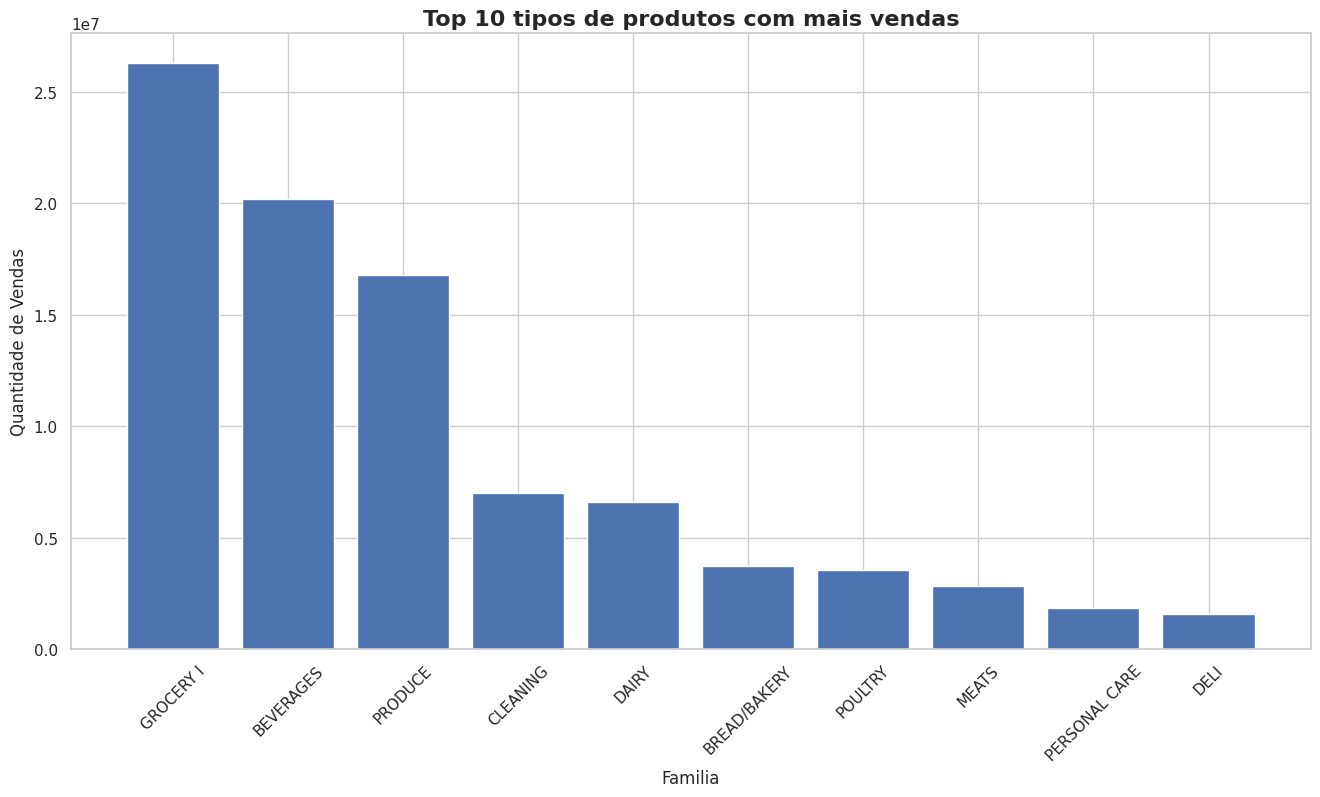

In [ ]:
df_vendas_familia = train.groupby('family')['sales'].sum().reset_index()

df_top10_familia = df_vendas_familia.nlargest(10, 'sales').sort_values('sales', ascending=False)


plt.figure(figsize=(16, 8))
plt.bar(df_top10_familia['family'], df_top10_familia['sales'], color='b')
plt.title('Top 10 tipos de produtos com mais vendas', fontsize=16, fontweight='bold')
plt.xlabel('Familia', fontsize=12)
plt.ylabel('Quantidade de Vendas', fontsize=12)
plt.xticks(df_top10_familia['family'], rotation=45)
plt.show()

- Os produtos mais vendidos são os produtos categorizados como "Grocery I", que geralmente são produtos alimentícios e de uso diário de supermercado, por exemplo arroz, feijão, açucar, óleo e enlatados.

- O segundo tipo de produto mais vendido são "Beverages", que são refrigerantes, sucos, chás e outros produtos dentro dessa categoria.

- O top 3 representa uma quantidade significativa das vendas totais do super mercado.

### Verificando a quantidade de vendas por ano com e sem promoção

In [ ]:
# criando uma flag pra verificar se o produto estava em promoção ou não
train['flag_promotion'] = train['onpromotion'].apply(lambda x: 1 if x > 0 else 0)

# criando um dataframe agrupando por promoção e ano
df_promocao_ano = train.groupby(['year', 'flag_promotion'])['sales'].sum().reset_index()

df_promocao_ano.head()

,year,flag_promotion,sales
0,2014,0,1.399512e+07
1,2014,1,1.122537e+07
2,2015,0,6.359247e+06
3,2015,1,2.064779e+07
4,2016,0,5.296409e+06


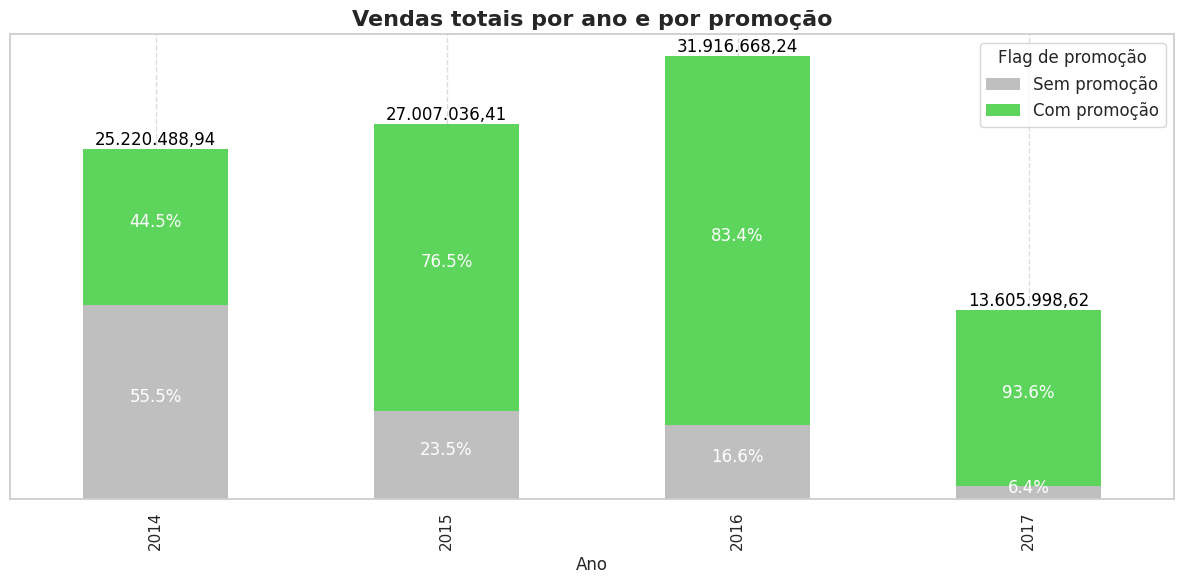

In [ ]:
def format_number(value):
  # formata o numero como float com duas casas decimais
  formatted_number = f'{value:,.2f}'
  # troca virgulas por pontos e pontos por virgula (estilo brasileiro)
  return formatted_number.replace(',','X').replace('.',',').replace('X','.')

# pivotando o df para obter os dados no formato correto
df_pivot = df_promocao_ano.pivot(index='year', columns='flag_promotion', values='sales').fillna(0)

# calculando os percentuais
df_percent = df_pivot.divide(df_pivot.sum(axis=1), axis=0) * 100

# plotando o gráfico em barras empilhadas
colors = ['#bfbfbf', '#5dd55d']
ax = df_pivot.plot(kind='bar', stacked=True, color=colors, edgecolor='none', figsize=(12,6))

# removendo o eixo vertical
ax.yaxis.set_visible(False)

# adicionando rotulos de percentual em cada barra
for i, year in enumerate(df_pivot.index):
  heights = df_pivot.loc[year]
  percentages = df_percent.loc[year]
  bottom = 0

  for j, (height, percentage) in enumerate(zip(heights, percentages)):
    rect = ax.patches[i]
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x() + width / 2
    y = rect.get_y() + height / 2
    ax.annotate(f'{percentage:.1f}%', xy=(x,y), ha='center', fontsize=12, color='white')
    bottom += height

    i += len(df_pivot.index)


# adicionando os valores totais no topo das barras
for i, year in enumerate(df_pivot.index):
  total_height = df_pivot.loc[year].sum()
  rect = ax.patches[df_pivot.shape[0]+i]
  width = rect.get_width()
  x = rect.get_x() + width / 2
  y = rect.get_y() + rect.get_height()
  formatted_number = format_number(total_height)
  ax.annotate(f'{formatted_number}', xy=(x,y), ha='center', va='bottom', fontsize=12, color='black')

# adicionando rotulos e titulo
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas totais por ano e por promoção', fontsize=16, fontweight='bold')
plt.legend(title='Flag de promoção', labels=['Sem promoção','Com promoção'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

- É possível observar que com o passar dos anos a quantidade de produtos vendidos aumentou;

- Isso também pode ser notado no número de vendas com promoção, onde a porcentagem de produtos vendidos com promoção aumenta no decorrer dos anos;

- O valor de vendas do ano de 2017 está baixo pois só temos dados até maior de 2017.

## Verificando o impacto do preço do petróleo nas vendas

In [ ]:
# importando a base de dados
df_oil = pd.read_csv('/content/drive/MyDrive/2 - Projetos Portfolio/Previsão de demanda/Base de dados/oil.csv')
df_oil.head()

,date,price
0,2014-01-02,95.14
1,2014-01-03,93.66
2,2014-01-06,93.12
3,2014-01-07,93.31
4,2014-01-08,91.90


In [ ]:
# verificando o range temporal da base
print(f'A base de dados contém dados de {df_oil["date"].min()} até {df_oil["date"].max()}')

A base de dados contém dados de 2014-01-02 até 2017-08-31


In [ ]:
# Verificando os tipos das colunas
df_oil.dtypes

,0
date,object
price,float64


In [ ]:
# transformando a coluna date em datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

# criando as colunas Mês, Ano e Mês de referência
df_oil['month'] = df_oil['date'].dt.month
df_oil['year'] = df_oil['date'].dt.year
df_oil['month_reference'] = df_oil['date'].dt.strftime('%Y%m')

df_oil.head()

,date,price,month,year,month_reference
0,2014-01-02,95.14,1,2014,201401
1,2014-01-03,93.66,1,2014,201401
2,2014-01-06,93.12,1,2014,201401
3,2014-01-07,93.31,1,2014,201401
4,2014-01-08,91.90,1,2014,201401


### Visualizando graficamente o preço do petróleo no decorrer do tempo

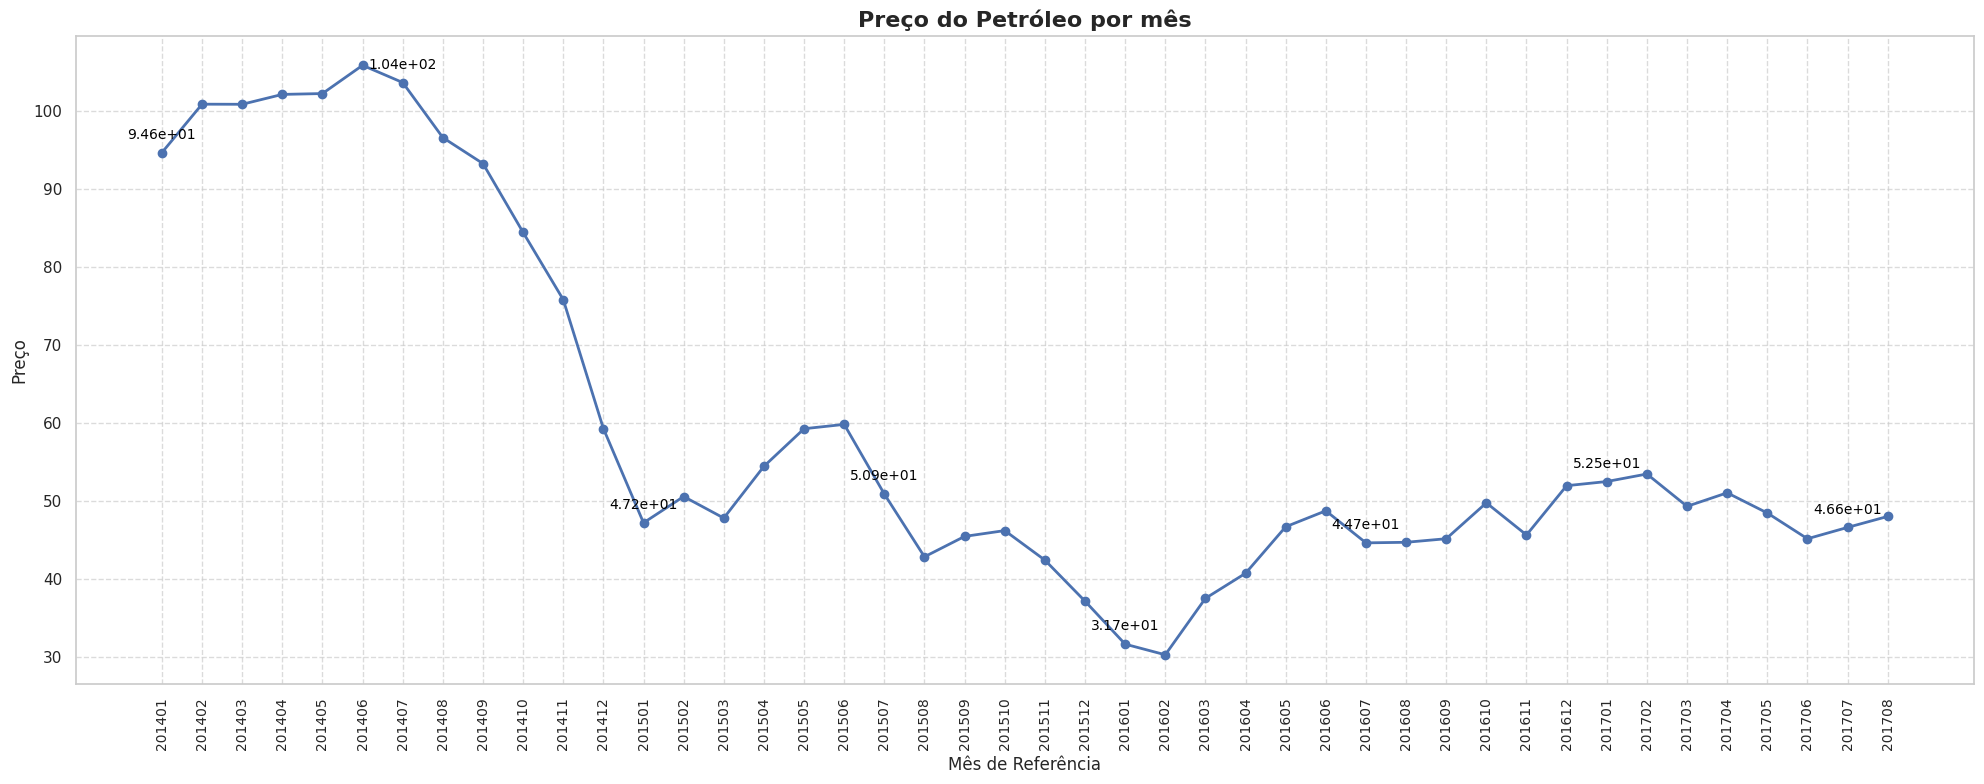

In [ ]:
df_preco_mes_petroleo = df_oil.groupby('month_reference')['price'].mean().reset_index()

# Definindo o estilo do seaborn
sns.set(style='whitegrid')

# Plotando um gráfico de linhas
plt.figure(figsize=(20, 8))
plt.plot(df_preco_mes_petroleo['month_reference'], df_preco_mes_petroleo['price'], marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Preço', fontsize=12)
plt.title('Preço do Petróleo por mês', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para alguns pontos
for i in range(0, len(df_preco_mes_petroleo), 6):
  plt.annotate(f'{df_preco_mes_petroleo["price"].iloc[i]:.2e}',
  (df_preco_mes_petroleo["month_reference"].iloc[i], df_preco_mes_petroleo["price"].iloc[i]),
  textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10, color='black')

plt.show()

* Avaliando a variação no preço do petróleo é possível perceber que seu preço esteve mais alto no mesmo momento em que houve uma grande variação nas vendas de produtos, porém a variação do petróleo não seguiu o mesmo padrão;

* Porém o aumento e a estabilidade de vendas pós período de variação pode estar relacionado a dimuição do preço do petróleo, pois essa diminuição impacta direto no preço do produto final no mercado.